In [1]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [2]:
# dy / dt = f(t, y)
# y(t0) = y0

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [4]:
def exponential_decay(t, y):
    return -0.5 * y

In [5]:
# t_eval=np.linspace(0, 10, 100)
t_eval=None
sol = solve_ivp(exponential_decay, [0, 10], [2,4,8], t_eval=t_eval)

In [6]:
sol.t

array([ 0.        ,  0.11487653,  1.26364188,  3.06061781,  4.81611105,
        6.57445806,  8.33328988, 10.        ])

In [7]:
sol.y

array([[2.        , 1.88836035, 1.06327177, 0.43319312, 0.18017253,
        0.07483045, 0.03107158, 0.01350781],
       [4.        , 3.7767207 , 2.12654355, 0.86638624, 0.36034507,
        0.14966091, 0.06214316, 0.02701561],
       [8.        , 7.5534414 , 4.25308709, 1.73277247, 0.72069014,
        0.29932181, 0.12428631, 0.05403123]])

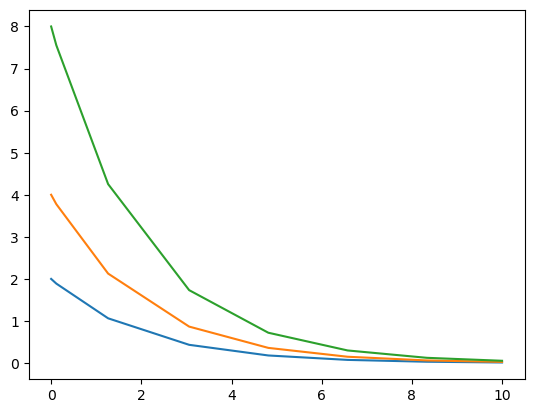

In [8]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[2])
# plt.yscale('log')

Cannon fired upward with terminal event upon impact. The terminal and direction fields of an event are applied by monkey patching a function. Here y[0] is position and y[1] is velocity. The projectile starts at position 0 with velocity +10. Note that the integration never reaches t=100 because the event is terminal.

In [9]:
def upward_cannon(t, y): return [y[1], -0.5]
def hit_ground(t, y): return y[0]
hit_ground.terminal = True
hit_ground.direction = -1

In [10]:
hit_ground.terminal

True

In [11]:
# could use this 'monkey-patching' in PN to stop integrating when
# v > 1?
# of when we reach MECO frequency?

In [12]:
sol = solve_ivp(upward_cannon, [0, 100], [0, 10], events=hit_ground)

In [13]:
sol.t_events

[array([40.])]

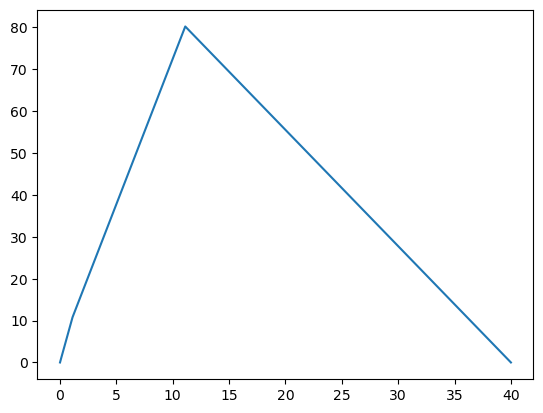

In [14]:
plt.plot(sol.t, sol.y[0])
# plt.plot(sol.t, sol.y[1])

In [15]:
# Lotka-Volterra equations

$$
\frac{dx}{dt} = a x - b x y
$$

$$
\frac{dy}{dt} = d x y - c y
$$

In [16]:
def lotkavolterra(t, z, a, b, c, d):
    x, y, = z
    return [a*x - b*x*y, -c*y + d*x*y]

In [17]:
sol = solve_ivp(lotkavolterra, [0, 15], [10, 5], args=(1.5, 1, 3, 1), dense_output=True)

In [18]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.574e-02 ...  1.489e+01  1.500e+01]
        y: [[ 1.000e+01  7.787e+00 ...  4.975e-01  5.820e-01]
            [ 5.000e+00  6.958e+00 ...  1.209e-01  9.165e-02]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11ca55d20>
 t_events: None
 y_events: None
     nfev: 470
     njev: 0
      nlu: 0

In [19]:
t = np.linspace(0, 15, 100)

In [20]:
z = sol.sol(t)

In [21]:
z.shape

(2, 100)

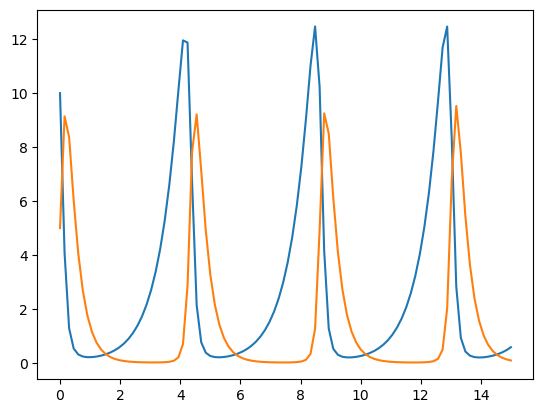

In [22]:
plt.plot(t, z[0])
plt.plot(t, z[1])

In [23]:
t[-1]

15.0

In [24]:
z[:,-1]

array([0.58202137, 0.09165412])

In [25]:
# solve backwards
# https://scicomp.stackexchange.com/questions/36524/trouble-with-backwards-time-integration-in-python
sol_bk = solve_ivp(lotkavolterra, [15, 0], [0.58202137, 0.09165412], args=(1.5, 1, 3, 1), dense_output=True)

In [26]:
sol_bk

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.500e+01  1.493e+01 ...  4.703e-02  0.000e+00]
        y: [[ 5.820e-01  5.257e-01 ...  8.468e+00  1.028e+01]
            [ 9.165e-02  1.095e-01 ...  6.475e+00  4.790e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11caee230>
 t_events: None
 y_events: None
     nfev: 434
     njev: 0
      nlu: 0

In [27]:
t_bk = np.flip(t)

In [28]:
z_bk = sol_bk.sol(t_bk)

In [29]:
np.mean(np.abs(np.flip(z_bk[0]) - z[0]))

0.06036470879401377

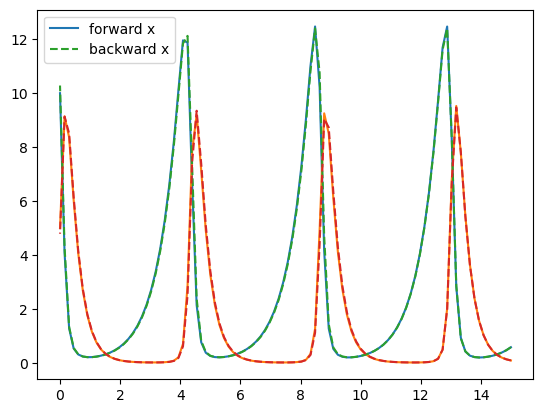

In [30]:
plt.plot(t, z[0], label='forward x')
plt.plot(t, z[1])
plt.plot(t_bk, z_bk[0], ls='--', label='backward x')
plt.plot(t_bk, z_bk[1], ls='--')

plt.legend()

# n-body

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

n= 3 # of bodys
G = 1 # constant
#m = np.random.randint(low=1,high=100,size=(n,)) # random values for masses
m = [1,1,1]

#----- Random Values for momentums and positions
P_0 = np.random.random_sample(size=(3,n)) # each column of the matrix represents 
# one vector
#R_0= np.random.random_sample(size=(3,n))
R_0= np.array([[0,0,0],[0,1,0],[0,1,0.96]])
Y_0 = np.concatenate((P_0,R_0),axis=1)


#----------------------------------------------
# Hamilton equations:

r_kDot = lambda t,p_k,m_k: (1/m_k)*p_k

p_kDot = lambda t,r_k,r_j,m_k,m_j: -G*(m_k*m_j/np.linalg.norm(r_k- r_j)**3)*(r_k- r_j)


def U(t,Y):
    
    Y = Y.reshape(3,2*n)
    Y = [Y[:,:n],Y[:,n:]]
    
    
    partial_Ham_p = np.array( [r_kDot(t,Y[0][i],m[i]) for i in  range(0,len(Y[0]))] ) 
    
    partial_Ham_r = np.array( [p_kDot(t,Y[1][k],Y[1][j],m[k],m[j]) for k in range(0,len(Y[1])) for j in range(0,k)] )
                          
    return np.concatenate((partial_Ham_r,partial_Ham_p),axis=1)

In [32]:
Sol = integrate.solve_ivp(U,y0=Y_0.flatten(),t_span= 
[0,10],dense_output=True,vectorized=True,t_eval=np.linspace(0,10,9999))
print (np.shape(Sol.y))
print (Sol.y)
r_vectors = Sol.y[9:,:]


(18, 9999)
[[ 1.21646674e-01  1.21646408e-01  1.21645610e-01 ... -3.79947649e-01
  -3.79951125e-01 -3.79954601e-01]
 [ 9.20235097e-01  9.19234549e-01  9.18233306e-01 ... -1.73141953e-01
  -1.73142857e-01 -1.73143761e-01]
 [ 8.63601815e-01  8.63602080e-01  8.63602876e-01 ...  1.59954293e+00
   1.59954909e+00  1.59955525e+00]
 ...
 [ 0.00000000e+00  9.63766834e-04  1.92753332e-03 ...  2.35345411e+00
   2.35366993e+00  2.35388665e+00]
 [ 1.00000000e+00  1.00075720e+00  1.00151441e+00 ... -1.68553377e-02
  -1.70969822e-02 -1.73375177e-02]
 [ 9.60000000e-01  9.60303680e-01  9.60606274e-01 ...  4.35252340e+00
   4.35382182e+00  4.35512019e+00]]


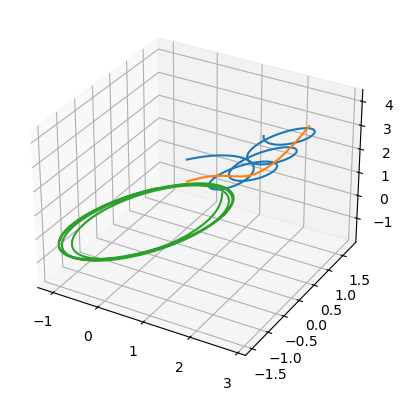

In [33]:


fig , axes = plt.subplots(subplot_kw={ "projection":"3d" })


axes.plot(r_vectors[6,:],r_vectors [7,:],r_vectors [8,:]) 
axes.plot(r_vectors[0,:],r_vectors [1,:],r_vectors [2,:])
axes.plot(r_vectors[3,:],r_vectors [4,:],r_vectors [5,:])
plt.show()

(3, 100)
(3, 100)
(3, 100)


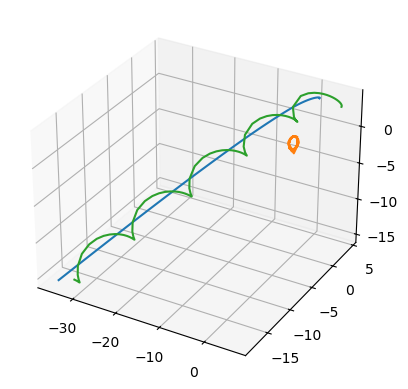

In [34]:
n=3
m = np.random.randint(low=1,high=3,size=(n,)) # random values for masses
m = np.ones((n,))
m[0]=2
#----- Random Values for momentums and positions
P_0 = np.random.random_sample(size=(3,n))/10 # each column of the matrix represents 
# one vector
# R_0 = np.random.random_sample(size=(3,n))*30
R_0 = np.array([
    [1,2,3],
    [2,3,4],
    [6,4,3],
])
Y_0 = np.concatenate((P_0,R_0),axis=1)

Sol = integrate.solve_ivp(U,y0=Y_0.flatten(),t_span=[0,100],dense_output=True,vectorized=True,t_eval=np.linspace(0,100,100))


TrayX = Sol.y[3*n::3,:]
TrayY = Sol.y[3*n+1::3,:]
TrayZ = Sol.y[3*n+2::3,:]

print(np.shape(TrayX))
print(np.shape(TrayY)) 
print(np.shape(TrayZ)) 

fig , axes = plt.subplots(subplot_kw={ "projection":"3d" })

for j in range(n):
   axes.plot(TrayX[j],TrayY[j],TrayZ[j])
plt.show()

In [35]:
Sol.t.shape

(100,)

In [36]:
TrayX[0].shape

(100,)

In [37]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2000

In [38]:
# TrayX = TrayX[:,::20]
# TrayY = TrayY[:,::20]
# TrayZ = TrayZ[:,::20]

In [39]:
len(TrayX[0])

100

In [40]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # Assuming your arrays are named x, y, and z
# # Make sure they have the same length (number of time steps)

# # fig, ax = plt.subplots(projection='3d')
# fig , ax = plt.subplots(subplot_kw={ "projection":"3d" })

# lines=[]
# for j in range(n):
#     line, = ax.plot([TrayX[j][0]], [TrayY[j][0]], [TrayZ[j][0]], marker='.')
#     lines.append(line)

# xlim=[TrayX.min(), TrayX.max()]
# ylim=[TrayY.min(), TrayY.max()]
# zlim=[TrayZ.min(), TrayZ.max()]

# ax.set(xlim=xlim, ylim=ylim, zlim=zlim)


# def animate(i):
#     # Update data for each frame
#     for j in range(n):
#         lines[j].set_data_3d(TrayX[j][:i], TrayY[j][:i], TrayZ[j][:i])
    
#     return line,


# # Animate with interval between frames (in milliseconds)
# ani = FuncAnimation(fig, animate, frames=len(TrayX[0]), interval=40)

# HTML(ani.to_jshtml())

# my 2-body 2D

$$
\vec{\ddot x}_{i} = \vec{F_{ij}}/m_i
$$

$$
\vec{F_{ij}} = G m_i m_j \frac{\hat d_{ij}}{|\vec{d}_{ij}|^2}
$$

where $\vec{d}_{ij}$ is the separation vector

$$
\vec{d}_{ij} = \vec{x}_i - \vec{x}_j
$$

We also re-write the 2nd order equation for acceleration as two 1st order ODEs for position and velocity.

$$
\vec{\dot x}_i = \vec{v}_i
$$

$$
\vec{\dot v}_i = \vec{F_{ij}}/m_i
$$

In [41]:
def unit_vector(x):
    mag = np.linalg.norm(x)
    return x / mag

In [42]:
unit_vector([1,1])

array([0.70710678, 0.70710678])

In [43]:
np.linalg.norm(unit_vector([1,1]))

0.9999999999999999

In [44]:
def rhs(t, y):

    n_bodies = 2
    n_variables = 2 # (x, v)
    n_dim = 2 # (x, y)
    # y.shape = (nbodies*2*ndim)
    y = y.reshape(n_bodies, n_variables, n_dim)
    # positions
    xs = y[:,0]
    # velocitites
    vs = y[:,1]

    # body 1
    d0 = xs[0] - xs[1]
    d0hat = unit_vector(d0)
    d0mag2 = np.linalg.norm(d0)**2

    F12 = -d0hat / d0mag2
    
    # body 2
    d1 = xs[1] - xs[0]
    d1hat = unit_vector(d1)
    d1mag2 = np.linalg.norm(d1)**2

    F21 = -d1hat / d1mag2

    # position
    p = [vs[0], vs[1]]

    # velocity
    v = [F12, F21]

    out = np.concatenate([p, v], axis=1).flatten()
    
    return out

In [45]:
x0 = [[1,0], [-1, 0]]
v0 = [[0,0.5], [0,-0.5]]
y0 = np.concatenate([x0, v0], axis=1)

t_start = 0
t_end = 50
t_num = 100

t_eval=np.linspace(t_start, t_end, t_num)

sol = solve_ivp(rhs, [t_start, t_end], y0=y0.flatten(), t_eval=t_eval, method='DOP853')

In [46]:
sol.t.shape

(100,)

In [47]:
sol.y.shape

(8, 100)

In [48]:
n_bodies = 2
n_variables = 2 # (x, v)
n_dim = 2 # (x, y)
n_times = len(t_eval)
ysol = sol.y.reshape(n_bodies, n_variables, n_dim, n_times)

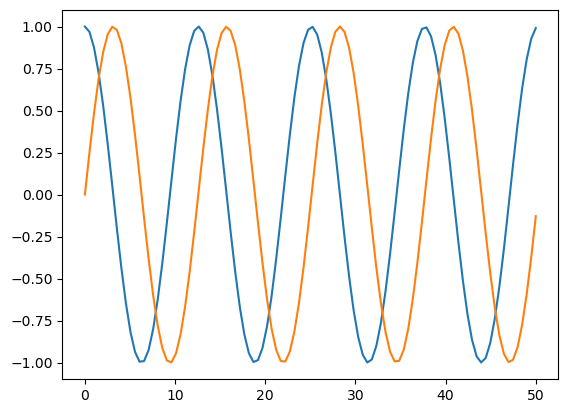

In [49]:
plt.plot(sol.t, ysol[0][0][0])
plt.plot(sol.t, ysol[0][0][1])

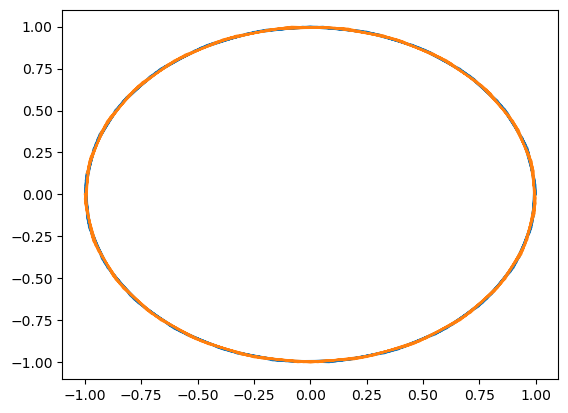

In [50]:
plt.plot(ysol[0][0][0], ysol[0][0][1])
plt.plot(ysol[1][0][0], ysol[1][0][1])

# my 2-body 3D

In [87]:
def rhs(t, y):

    n_bodies = 2
    n_variables = 2 # (x, v)
    n_dim = 3 # (x, y)
    # y.shape = (nbodies*2*ndim)
    y = y.reshape(n_bodies, n_variables, n_dim)
    # positions
    xs = y[:,0]
    # velocitites
    vs = y[:,1]

    # body 1
    d0 = xs[0] - xs[1]
    d0hat = unit_vector(d0)
    d0mag2 = np.linalg.norm(d0)**2

    F12 = -d0hat / d0mag2
    
    # body 2
    d1 = xs[1] - xs[0]
    d1hat = unit_vector(d1)
    d1mag2 = np.linalg.norm(d1)**2

    F21 = -d1hat / d1mag2

    # position
    p = [vs[0], vs[1]]

    # velocity
    v = [F12, F21]

    out = np.concatenate([p, v], axis=1).flatten()
    
    return out

In [102]:
x0 = [[1,0,0], [-1, 0, 0]]
v0 = [[0,0.5,0], [0,-0.5,0]]
y0 = np.concatenate([x0, v0], axis=1)

t_start = 0
t_end = 50
t_num = 100

t_eval=np.linspace(t_start, t_end, t_num)

sol = solve_ivp(rhs, [t_start, t_end], y0=y0.flatten(), t_eval=t_eval, method='DOP853')

In [103]:
sol.t.shape

(100,)

In [104]:
sol.y.shape

(12, 100)

In [105]:
n_bodies = 2
n_variables = 2 # (x, v)
n_dim = 3 # (x, y)
n_times = len(t_eval)
ysol = sol.y.reshape(n_bodies, n_variables, n_dim, n_times)

In [106]:
plt.plot(sol.t, ysol[0][0][0])
plt.plot(sol.t, ysol[0][0][1])

In [107]:
plt.plot(ysol[0][0][0], ysol[0][0][1])
plt.plot(ysol[1][0][0], ysol[1][0][1])

In [110]:
# %matplotlib widget
%matplotlib inline

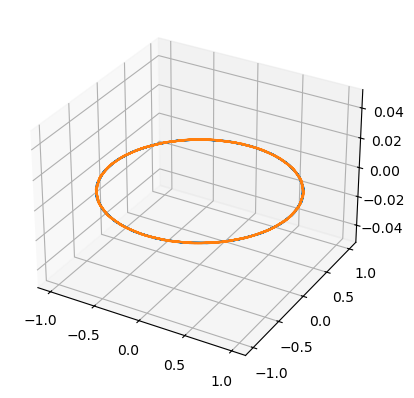

In [112]:
fig , axes = plt.subplots(subplot_kw={ "projection":"3d" })

axes.plot(ysol[0][0][0], ysol[0][0][1], ysol[0][0][2])
axes.plot(ysol[1][0][0], ysol[1][0][1], ysol[1][0][2])
plt.show()

# my 3-body 3D

In [272]:
def rhs(t, y, m):

    # n_bodies = 3
    n_variables = 2 # (x, v)
    n_dim = 3 # (x, y)
    # y.shape = (nbodies*2*ndim)
    y = y.reshape(n_bodies, n_variables, n_dim)
    # positions
    xs = y[:,0]
    # velocitites
    vs = y[:,1]

    Fs = np.zeros((n_bodies, 3))
    for i in range(n_bodies):
        for j in range(n_bodies):
            if i!=j:
                d0 = xs[i] - xs[j]
                d0hat = unit_vector(d0)
                d0mag2 = np.linalg.norm(d0)**2
            
                Fij = -d0hat / (d0mag2 + 1e-6)  
                Fs[i] += Fij / m[j]

    # position
    p = [vs[i] for i in range(n_bodies)]

    # velocity
    v = Fs

    out = np.concatenate([p, v], axis=1).flatten()
    
    return out

In [273]:
np.array(x0).shape

(4, 3)

In [499]:
np.random.seed(0)
# n_bodies = 5
n_bodies = 10
n_variables = 2 # (x, v)
n_dim = 3 # (x, y)

# x0 = [[1,0,0], [-1, 0, 0], [0, 1, 0]]
# v0 = [[0,0.5,0], [0,-0.5,0], [-0.5,0,0.1]]
# ms=[5,1,1]

# x0 = [[0,0,0], [-1, 0, 0], [1, 0, 0]]
# v0 = [[1e-6,0,0], [0,-0.5,0], [0,0.5,0.]]
# ms=[1.2,1,1]

x0 = np.random.uniform(low=-2, high=2, size=(n_bodies, 3))
v0 = np.random.uniform(low=-0.1, high=0.1, size=(n_bodies, 3))
ms=np.random.uniform(low=1, high=2, size=(n_bodies))



y0 = np.concatenate([x0, v0], axis=1)

t_start = 0
t_end = 500
t_dt = 0.01
t_eval=np.arange(t_start, t_end, t_dt)
t_num = len(t_eval)

In [500]:
%%time
# initial conditions y0 are flattened into a 1D list/array
# inside `rhs` we have to unpack this properly.
# and then from the `sol` variable we have to again unpack the `sol.y` data
# annoying
sol = solve_ivp(rhs, [t_start, t_end], y0=y0.flatten(), t_eval=t_eval, method='DOP853', args=[ms])

CPU times: user 36.9 s, sys: 84.6 ms, total: 37 s
Wall time: 37 s


In [501]:
sol.t.shape

(50000,)

In [502]:
sol.y.shape

(60, 50000)

In [503]:

n_times = len(t_eval)
ysol = sol.y.reshape(n_bodies, n_variables, n_dim, n_times)

In [504]:
%matplotlib inline

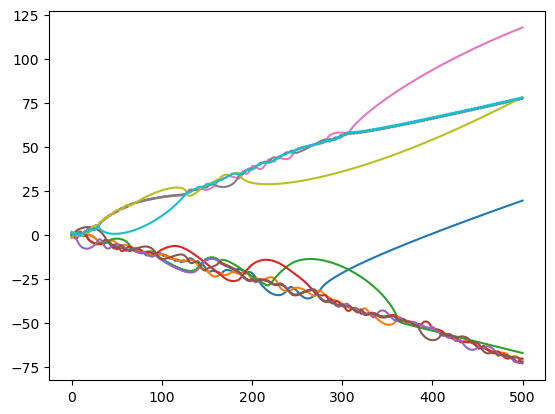

In [505]:
plt.figure()
for i in range(n_bodies):
    plt.plot(sol.t, ysol[i][0][0])
plt.show()

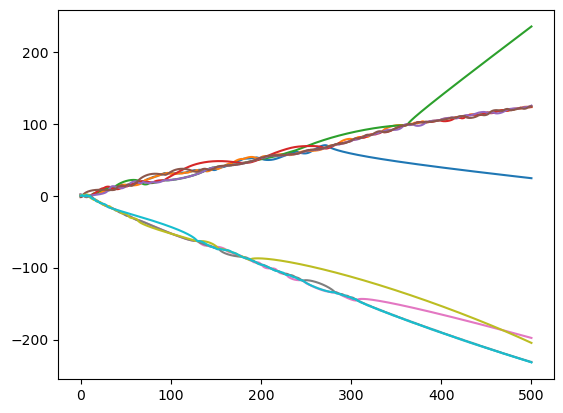

In [506]:
plt.figure()
for i in range(n_bodies):
    plt.plot(sol.t, ysol[i][0][1])
plt.show()

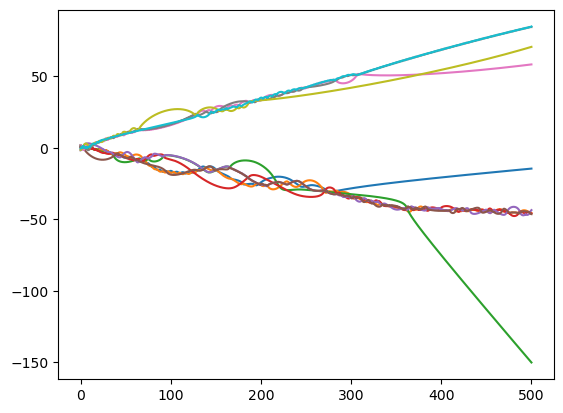

In [507]:
plt.figure()
for i in range(n_bodies):
    plt.plot(sol.t, ysol[i][0][2])
plt.show()

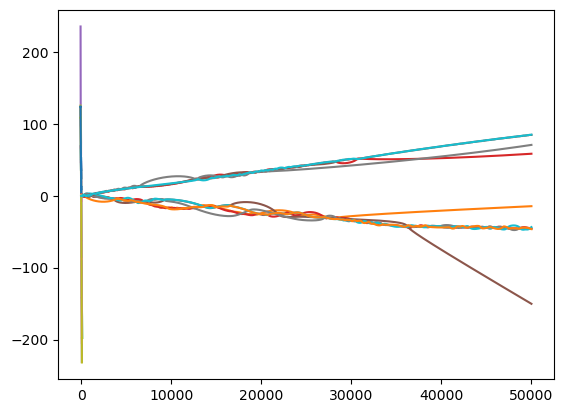

In [508]:
plt.figure()
for i in range(n_bodies):
    plt.plot(ysol[i][0][0], ysol[i][0][1], ysol[i][0][2])

In [509]:
import os

In [510]:
# os.makedirs('plots')

In [511]:
from tqdm.notebook import trange, tqdm


In [512]:
# !rm -rf plots/*

In [513]:
n_times

50000

In [518]:
%%time
# %matplotlib widget
lag = 100
# max_times = n_times
max_times = 10000
every = 10
for j, i_t in enumerate(trange(0, max_times-lag, every)):
    fig , axes = plt.subplots(subplot_kw={ "projection":"3d" })
    for i in range(n_bodies):
        axes.plot(ysol[i][0][0][i_t:i_t+lag], ysol[i][0][1][i_t:i_t+lag], ysol[i][0][2][i_t:i_t+lag])
    axes.set_xlim3d(-1.5, 1.5)
    axes.set_ylim3d(-1.5, 1.5)
    axes.set_zlim3d(-1.5, 1.5)
    axes.set_axis_off()
    plt.savefig('plots/'+f'{j}'.zfill(6))
    plt.close()

  0%|          | 0/990 [00:00<?, ?it/s]

CPU times: user 18.7 s, sys: 1.04 s, total: 19.7 s
Wall time: 19.6 s


In [519]:
# https://superuser.com/a/1747131

In [520]:
!ffmpeg -f image2 -r 25 -pattern_type glob -i 'plots/*.png' -vcodec libx264 -crf 22 video.mp4 -y

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

In [517]:
# (base) ode-example $ ffmpeg -f image2 -r 60 -pattern_type glob -i 'plots/*.png' -vcodec libx264 -crf 22 video.mp4